In [1]:
# load all associated modules
import os
import umap
import joblib
import numpy as np
import pandas as pd
from Bio import PDB
from Bio.PDB.DSSP import DSSP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# function to extract helical segments (DSSP based)
def extract_helical_segments(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_file)
    model = structure[0]

    try:
        dssp = DSSP(model, pdb_file, dssp="mkdssp")
    except Exception as e:
        print(f"Skipping {pdb_file}: DSSP failed ({e})")
        return []

    helices = []
    current_helix = []

    for key in dssp.keys():
        aa = dssp[key]
        ss = aa[2]  # Secondary structure
        if ss == 'H':
            res = model[key[0]][key[1]]
            if 'CA' in res:
                current_helix.append(res['CA'].get_coord())
        else:
            if len(current_helix) >= 4:
                helices.append(np.array(current_helix))
            current_helix = []
    if len(current_helix) >= 4:
        helices.append(np.array(current_helix))

    return helices

# define vectors, angles & tilt between segments
def angle_between(v1, v2):
    dot = np.dot(v1, v2)
    cos = np.clip(dot / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)
    return np.degrees(np.arccos(cos))

def analyze_helices(helices):
    z_axis = np.array([0, 0, 1])
    vectors = []
    for helix in helices:
        pca = PCA(n_components=1)
        pca.fit(helix)
        v = pca.components_[0]
        if v[2] < 0:  # Align with +Z
            v = -v
        vectors.append(v)

    angles = [angle_between(vectors[i], vectors[i + 1])
              for i in range(len(vectors) - 1)]
    tilts = [angle_between(v, z_axis) for v in vectors]

    return {
        "avg_angle_between": np.mean(angles) if angles else np.nan,
        "std_angle_between": np.std(angles) if angles else np.nan,
        "avg_tilt": np.mean(tilts),
        "std_tilt": np.std(tilts)
    }

In [3]:
# ------------------------------------------------------------------
# Analyze All PDBs in a certain folder to extract features #########
# ------------------------------------------------------------------
# define the folder
folder = "msm_pcca/"
output_file = "msm_pcca/angles_tilt.dat"
# or...
# folder = "pdbs/"
# output_file = "pdbs/angles_tilt.dat"


with open(output_file, "w") as out:
    out.write("# PDB_Name avg_angle std_angle avg_tilt std_tilt\n")

    for fname in os.listdir(folder):
        if not fname.endswith(".pdb"):
            continue
        fpath = os.path.join(folder, fname)
        helices = extract_helical_segments(fpath)

        if len(helices) < 2:
            print(f"Skipping {fname}: fewer than 2 helices")
            continue

        result = analyze_helices(helices)
        out.write(f"{fname:<20} {result['avg_angle_between']:.2f} {result['std_angle_between']:.2f} "
                  f"{result['avg_tilt']:.2f} {result['std_tilt']:.2f}\n")

print(f"\n✅ Results written to {output_file}")


✅ Results written to msm_pcca/angles_tilt.dat


/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/517289868.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(input_file, delim_whitespace=True, comment="#", header=None,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Clustering complete. Output written to pdbs/angles_tilt_clusters.dat


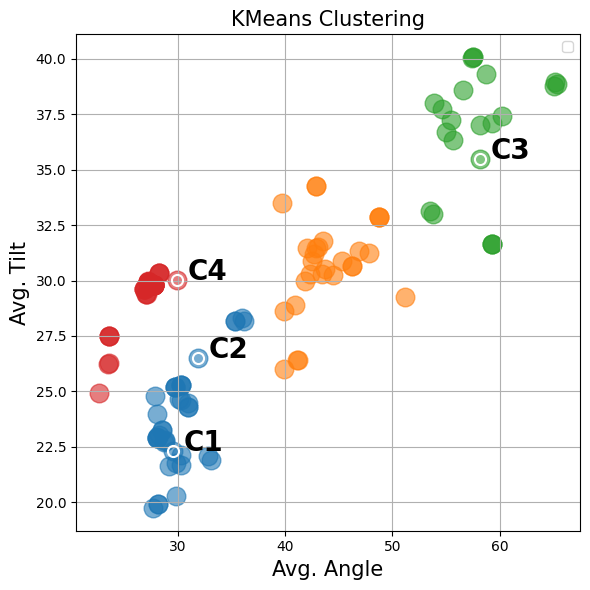

In [3]:
# Initial Clustering based on k-means
# ===================================

# Parameters
input_file = "pdbs/angles_tilt.dat"
output_file = "pdbs/angles_tilt_clusters.dat"
n_clusters = 4  # You can change this to any number of clusters

# Load the Data
data = pd.read_csv(input_file, delim_whitespace=True, comment="#", header=None,
                   names=["PDB_Name", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])

# Extract features for clustering
features = data[["avg_angle", "avg_tilt"]]

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=n_clusters, max_iter=300, random_state=42)
labels = kmeans.fit_predict(features)

# Add cluster labels to the data
data["Cluster"] = labels

# Organize PDBs by Cluster
clusters = [[] for _ in range(n_clusters)]
for _, row in data.iterrows():
    clusters[row["Cluster"]].append(row["PDB_Name"])

# Transpose cluster lists to rows for writing
max_len = max(len(cluster) for cluster in clusters)
rows = []
for i in range(max_len):
    row = []
    for cluster in clusters:
        row.append(cluster[i] if i < len(cluster) else "")
    rows.append(row)

# Write Output
column_width = 20  # Adjust as needed for longest PDB name

with open(output_file, "w") as f:
    header = "".join(f"{f'cluster #{i+1}':<{column_width}}" for i in range(n_clusters))
    f.write(header + "\n")
    for row in rows:
        line = "".join(f"{pdb:<{column_width}}" for pdb in row)
        f.write(line + "\n")

print(f"Clustering complete. Output written to {output_file}")

# === Plotting ===
plt.figure(figsize=(6, 6))
# colors = plt.cm.tab10(np.arange(n_clusters))  # distinct colors

# Generate default colors
original_colors = plt.cm.tab10(np.arange(n_clusters))

# Rearrange colors according to the mapping:
# new_colors[0] = original_colors[3]  # cluster 1 gets cluster 4's color
# new_colors[1] = original_colors[1]  # cluster 2 remains the same
# new_colors[2] = original_colors[0]  # cluster 3 gets cluster 1's color
# new_colors[3] = original_colors[2]  # cluster 4 gets cluster 3's color
color_mapping = [0, 1, 2, 3]
colors = original_colors[color_mapping]

for cluster in range(n_clusters):
    cluster_data = data[data["Cluster"] == cluster]
    plt.scatter(cluster_data["avg_angle"], cluster_data["avg_tilt"],
                color=colors[cluster], s=180, alpha=0.6)

# Coordinates for the circles
points = {
    "C2": (31.84, 26.51),
    "C3": (58.18, 35.50),
    "C1": (29.53, 22.29),
    "C4": (29.90, 30.01),
}

pointsA = {
    "AF1": (28.04, 21.82),
    "AF2": (51.01, 31.87),
    "AF3": (29.05, 25.93),
    "AF4": (47.95, 30.98),
}

# Add circles and labels to only the second subplot
for label, (x, y) in points.items():
    plt.plot(x, y, marker='o', color='white', markersize=8, 
               markerfacecolor='none', markeredgewidth=1.5)
    plt.text(x + 1, y, label, fontsize=20, color='black',weight='bold')

plt.xlabel("Avg. Angle",fontsize='15')
plt.ylabel("Avg. Tilt",fontsize='15')
# plt.xlim([18,70])
# plt.ylim([18,40])
plt.title("KMeans Clustering",fontsize='15')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Kmeans_Clustering.png", bbox_inches='tight', dpi=600, format='png')
plt.show()

/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_1868/3614168176.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(input_file, delim_whitespace=True, comment="#", header=None,


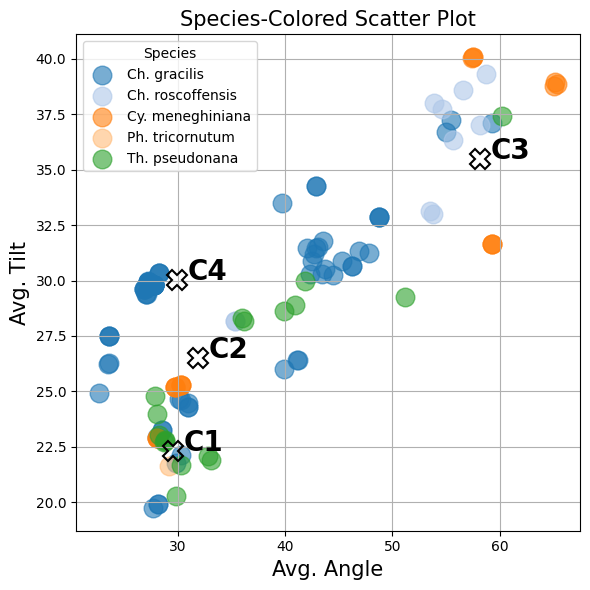

In [14]:
# Input file
input_file = "pdbs/angles_tilt_species.dat"

# Load the Data
data = pd.read_csv(input_file, delim_whitespace=True, comment="#", header=None,
                   names=["PDB_Name", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])

# Species mapping based on PDB prefixes
species_map = {
    "6A2W": "Ph. tricornutum",
    "6J3Y": "Ch. gracilis",
    "6J3Z": "Ch. gracilis",
    "6J40": "Ch. gracilis",
    "6JLU": "Ch. gracilis",
    "6L4U": "Ch. gracilis",
    "7VD5": "Ch. gracilis",
    "7VD6": "Ch. gracilis",
    "8IWH": "Th. pseudonana",
    "8J0D": "Th. pseudonana",
    "8JP3": "Th. pseudonana",
    "8J5K": "Cy. meneghiniana",
    "8J7Z": "Cy. meneghiniana",
    "8W4O": "Cy. meneghiniana",
    "8W4P": "Cy. meneghiniana",
    "8WCK": "Ch. gracilis",
    "8WCL": "Ch. gracilis",
    "9KQB": "Ch. roscoffensis"
}

# Function to map each PDB to a species
def get_species(pdb_name):
    prefix = pdb_name.split("_")[0]
    return species_map.get(prefix, "Unknown")

# Add species to DataFrame
data["Species"] = data["PDB_Name"].apply(get_species)

# Assign colors to species
unique_species = sorted(data["Species"].unique())
color_map = dict(zip(unique_species, plt.cm.tab20.colors[:len(unique_species)]))

# Plotting
plt.figure(figsize=(6, 6))

for species in unique_species:
    species_data = data[data["Species"] == species]
    plt.scatter(species_data["avg_angle"], species_data["avg_tilt"],
                color=color_map[species], s=180, alpha=0.6, label=species)

# Coordinates for the circles
points = {
    "C2": (31.84, 26.51),
    "C3": (58.18, 35.50),
    "C1": (29.53, 22.29),
    "C4": (29.90, 30.01),
}

# Add circles and labels
for label, (x, y) in points.items():
    plt.plot(x, y, marker='X', color='black', markersize=15,
             markerfacecolor='none', markeredgewidth=1.5)
    plt.text(x + 1, y, label, fontsize=20, color='black', weight='bold')

plt.xlabel("Avg. Angle", fontsize=15)
plt.ylabel("Avg. Tilt", fontsize=15)
plt.title("Species-Colored Scatter Plot", fontsize=15)
plt.grid(True)
plt.legend(title="Species", fontsize=10)
plt.tight_layout()
plt.savefig("Species_Clustering.png", bbox_inches='tight', dpi=600, format='png')
plt.show()

In [4]:
# MACHINE LEARNING === RANDOM FOREST #############
# ================================================
cluster_file = "pdbs/angles_tilt_clusters.dat"

cluster_df = pd.read_csv(cluster_file, delim_whitespace=True, skiprows=1, header=None)
n_clusters = cluster_df.shape[1]

# Flatten the table into a long format: (PDB_Name, Cluster)
pdb_cluster_list = []
for col in range(n_clusters):
    for pdb in cluster_df[col].dropna():
        pdb_cluster_list.append((pdb, col+1))  # col is cluster index

cluster_labels_df = pd.DataFrame(pdb_cluster_list, columns=["PDB_Name", "Cluster"])

# Load Features
features_df = pd.read_csv("pdbs/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,
                          names=["PDB_Name", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])

# Merge Features with Labels
merged_df = pd.merge(features_df, cluster_labels_df, on="PDB_Name")

# Features and labels
X = merged_df[["avg_angle", "avg_tilt"]]
y = merged_df["Cluster"]
print(merged_df)

        PDB_Name  avg_angle  std_angle  avg_tilt  std_tilt  Cluster
0    7VD5_17.pdb      23.61      12.24     26.28      7.22        4
1    6J3Y_14.pdb      27.26       7.85     29.94     13.03        4
2    6J40_12.pdb      27.24       7.86     29.93     13.01        4
3     9KQB_g.pdb      35.32      16.18     28.16      5.92        1
4     9KQB_1.pdb      58.13      31.59     37.03     22.24        3
..           ...        ...        ...       ...       ...      ...
117  7VD5_32.pdb      28.49       9.58     23.24      7.89        1
118       C2.pdb      31.84      12.36     26.51      7.66        1
119       C3.pdb      58.18      21.69     35.50     24.90        3
120       C1.pdb      29.53       7.52     22.29      9.33        1
121       C4.pdb      29.90      23.82     30.01      2.89        2

[122 rows x 6 columns]


/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/942117889.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cluster_df = pd.read_csv(cluster_file, delim_whitespace=True, skiprows=1, header=None)
/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/942117889.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv("pdbs/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,


In [5]:
# MACHINE LEARNING === RANDOM FOREST #############
# ================================================
# Minkowski style metrics: euclidean, manhattan, chebyshev, minkowski
# spatial metrics: canberra, braycurtis, haversine
# Normalized spatial metrics: mahalanobis, wminkowski, seuclidean
# Angular and correlation metrics: cosine, correlation
# binary data: hamming, jaccard, dice, russellrao, kulsinski, rogerstanimoto sokalmichener, sokalsneath, yule
# parameters for UMAP clustering 
n_neighbors=10
min_dist=0.2
metric='euclidean'

# ------------------ SCALING + UMAP ------------------ #
reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbors, min_dist=min_dist,metric=metric)
X_umap = reducer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
import joblib
joblib.dump(clf, "angles_rf_model.pkl")

/Volumes/SSD_APFS/Users/vdasnet/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Volumes/SSD_APFS/Users/vdasnet/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       0.80      0.80      0.80         5
           3       0.80      0.67      0.73         6
           4       0.86      1.00      0.92         6

    accuracy                           0.88        25
   macro avg       0.86      0.87      0.86        25
weighted avg       0.88      0.88      0.88        25



['angles_rf_model.pkl']

In [6]:
# MACHINE PREDICTION === RANDOM FOREST ############
###################################################
input_features = "msm_pcca/angles_tilt.dat"
output_file = "msm_pcca/prediction_clusters.dat"

features_input = pd.read_csv(input_features, delim_whitespace=True, comment="#", header=None,
                          names=["PDB_Name", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])

# Combine the Series into a DataFrame
features_data = pd.concat(
    [
        features_input["avg_angle"],
        features_input["avg_tilt"]
    ],
    axis=1
)

# Optional: Rename columns if needed (only if you want to change them)
features_data.columns = ["avg_angle", "avg_tilt"]

# Now print the DataFrame
print(features_data)

   avg_angle  avg_tilt
0      31.84     26.51
1      58.18     35.50
2      28.04     21.82
3      29.53     22.29
4      29.05     25.93
5      51.01     31.87
6      29.90     30.01
7      47.95     30.98


/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/96789440.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_input = pd.read_csv(input_features, delim_whitespace=True, comment="#", header=None,


In [7]:
# === Predict Clusters and Store Features + Probabilities ===
unknown_names = features_input["PDB_Name"]
unknown_umap = reducer.transform(features_data)
unknown_preds = clf.predict(unknown_umap)
unknown_probs = clf.predict_proba(unknown_umap)
print("\n🧪 Predictions for Unknowns:\n")

for name, pred, prob in zip(unknown_names, unknown_preds, unknown_probs):
    print(f"{name}: {pred} (", ", ".join([f"{c}:{p:.2f}" for c, p in zip(clf.classes_, prob)]), ")")

/Volumes/SSD_APFS/Users/vdasnet/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



🧪 Predictions for Unknowns:

C2.pdb: 1 ( 1:1.00, 2:0.00, 3:0.00, 4:0.00 )
C3.pdb: 3 ( 1:0.00, 2:0.00, 3:1.00, 4:0.00 )
AF1.pdb: 1 ( 1:1.00, 2:0.00, 3:0.00, 4:0.00 )
C1.pdb: 1 ( 1:1.00, 2:0.00, 3:0.00, 4:0.00 )
AF3.pdb: 1 ( 1:1.00, 2:0.00, 3:0.00, 4:0.00 )
AF2.pdb: 2 ( 1:0.00, 2:0.97, 3:0.03, 4:0.00 )
C4.pdb: 4 ( 1:0.00, 2:0.32, 3:0.00, 4:0.68 )
AF4.pdb: 2 ( 1:0.00, 2:1.00, 3:0.00, 4:0.00 )


/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/2194499949.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


Mean Squared Error: 0.7939
R² Score: 0.9460


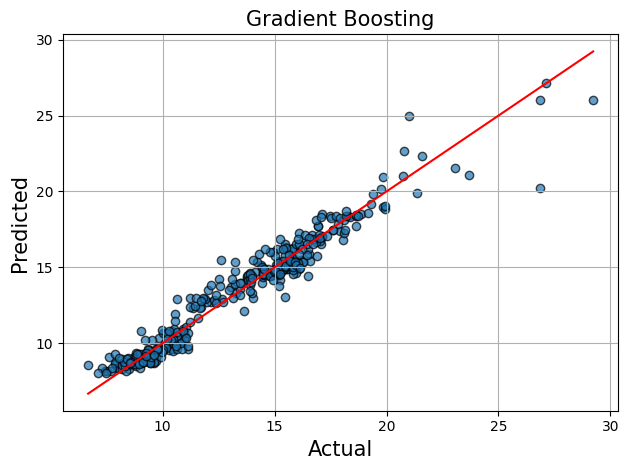

['coupl/coupl_model.pkl']

In [8]:
# Load the data
file_path = 'coupl/combined.dat'
data = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Extract features (columns 1 and 3 => indices 0 and 2), and target (last column => index 4)
X = data[[0, 2]]
y = data[3]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model using Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.xlabel("Actual",fontsize='15')
plt.ylabel("Predicted",fontsize='15')
plt.title("Gradient Boosting",fontsize='15')
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.grid(True)
plt.tight_layout()
plt.savefig("Coupling_RF.png", bbox_inches='tight', dpi=600, format='png')
plt.show()

joblib.dump(model, 'coupl/coupl_model.pkl')

In [9]:
# Load the trained/ saved ML model
model = joblib.load('coupl/coupl_model.pkl')

# load input file with features
input_path = 'pdbs/angles_tilt.dat'  # Replace with your actual file path
input_data = pd.read_csv(input_path, delim_whitespace=True, comment="#", header=None,
                   names=["PDB_Name", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])
X_input = input_data[["avg_angle", "avg_tilt"]]

# predictions
predictions = model.predict(X_input)

# add prediction to the labels
results = pd.DataFrame({
    'PDB_Name': input_data.iloc[:, 0],
    'Prediction': predictions
})

# === OUTPUT RESULTS ===
print(results)

# === SAVE TO FILE ===
output_path = 'pdbs/coupl_predictions.dat'
with open(output_path, 'w') as f:
    f.write("# PDB_Name Prediction\n")
    for _, row in results.iterrows():
        f.write(f"{row['PDB_Name']} {row['Prediction']}\n")

        PDB_Name  Prediction
0    7VD5_17.pdb    9.097597
1    6J3Y_14.pdb    7.509132
2    6J40_12.pdb    7.509132
3     9KQB_g.pdb    9.153597
4     9KQB_1.pdb   26.539005
..           ...         ...
117  7VD5_32.pdb   12.310812
118       C2.pdb    9.476289
119       C3.pdb   26.408365
120       C1.pdb   13.075482
121       C4.pdb    7.654335

[122 rows x 2 columns]


/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/604008671.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  input_data = pd.read_csv(input_path, delim_whitespace=True, comment="#", header=None,
/Volumes/SSD_APFS/Users/vdasnet/opt/anaconda3/envs/pyemma/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/3338293047.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ft_core = pd.read_csv("pdbs/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,
/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/3338293047.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cpl_core = pd.read_csv("pdbs/coupl_predictions.dat", delim_whitespace=True, comment="#", header=None,


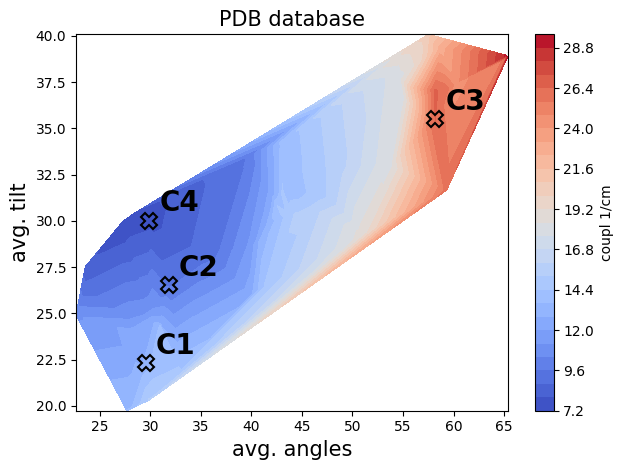

In [10]:
# Load data
ft_core = pd.read_csv("pdbs/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,
                      names=["PDB_Name", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])
cpl_core = pd.read_csv("pdbs/coupl_predictions.dat", delim_whitespace=True, comment="#", header=None,
                       names=["PDB_Name", "Prediction"])

# Align by PDB_Name
merged = pd.merge(ft_core, cpl_core, on="PDB_Name")

# build X_input: columns = [angle, tilt, prediction]
X_input = merged[["avg_angle", "avg_tilt", "Prediction"]].to_numpy()

# Plot with tricontourf for scattered data
cf_pdb = plt.tricontourf(X_input[:, 0], X_input[:, 1], X_input[:, 2],
                         levels=30, cmap='coolwarm')

# Add labels and colorbar
cbar = plt.colorbar(cf_pdb, label="coupl 1/cm")
plt.xlabel("avg. angles", fontsize=15)
plt.ylabel("avg. tilt", fontsize=15)
plt.title("PDB database", fontsize=15)

for label, (x, y) in points.items():
    plt.plot(x, y, marker='X', color='black', markersize=12, 
               markerfacecolor='none', markeredgewidth=1.5)
    plt.text(x + 1, y+0.5, label, fontsize=20, color='black',weight='bold')
plt.tight_layout()
plt.savefig("Coupling_predict.png", bbox_inches='tight', dpi=600, format='png')
plt.show()

In [11]:
# Load the Data
data_pdb = pd.read_csv("pdbs/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,
                   names=["PDB_Name", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])
x_pdb, y_pdb = data_pdb["avg_angle"], data_pdb["avg_tilt"]

data_xtc = pd.read_csv("md_traj/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,
                   names=["Frame", "avg_angle", "std_angle", "avg_tilt", "std_tilt"])
x_xtc, y_xtc = data_xtc["avg_angle"], data_xtc["avg_tilt"]

# Setup a 2D grid
xmin_pdb, xmax_pdb = x_pdb.min(), x_pdb.max()
ymin_pdb, ymax_pdb = y_pdb.min(), y_pdb.max()
xmin_xtc, xmax_xtc = x_xtc.min(), x_xtc.max()
ymin_xtc, ymax_xtc = y_xtc.min(), y_xtc.max()

# Choose bin resolution
nbins = 200
xi_pdb = np.linspace(xmin_pdb, xmax_pdb, nbins)
yi_pdb = np.linspace(ymin_pdb, ymax_pdb, nbins)
X_pdb, Y_pdb = np.meshgrid(xi_pdb, yi_pdb)
positions_pdb = np.vstack([X_pdb.ravel(), Y_pdb.ravel()])
xi_xtc = np.linspace(xmin_xtc, xmax_xtc, nbins)
yi_xtc = np.linspace(ymin_xtc, ymax_xtc, nbins)
X_xtc, Y_xtc = np.meshgrid(xi_xtc, yi_xtc)
positions_xtc = np.vstack([X_xtc.ravel(), Y_xtc.ravel()])

# KDE estimation
kde_pdb = gaussian_kde(np.vstack([x_pdb, y_pdb]))
Z_pdb = kde_pdb(positions_pdb).reshape(X_pdb.shape)
kde_xtc = gaussian_kde(np.vstack([x_xtc, y_xtc]))
Z_xtc = kde_xtc(positions_xtc).reshape(X_xtc.shape)

# convert to energy units
# Normalize to max = 0 (lowest energy)
Z_pdb /= Z_pdb.sum()
F_pdb = -np.log(Z_pdb)
F_pdb -= F_pdb.min()  # free energy relative to min (in units of kT)
Z_xtc /= Z_xtc.sum()
F_xtc = -np.log(Z_xtc)
F_xtc -= F_xtc.min()  # free energy relative to min (in units of kT)

# Mask very low density regions
F_masked_pdb = np.ma.masked_where(Z_pdb < 1e-20, F_pdb)  # mask very low P
F_masked_xtc = np.ma.masked_where(Z_xtc < 1e-19, F_xtc)  # mask very low P

/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/637912024.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_pdb = pd.read_csv("pdbs/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,
/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/637912024.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_xtc = pd.read_csv("md_traj/angles_tilt.dat", delim_whitespace=True, comment="#", header=None,
/var/folders/dr/kxt9x31d0_d5ptr51gqg6m3c0000gp/T/ipykernel_20569/637912024.py:39: RuntimeWarning: divide by zero encountered in log
  F_xtc = -np.log(Z_xtc)


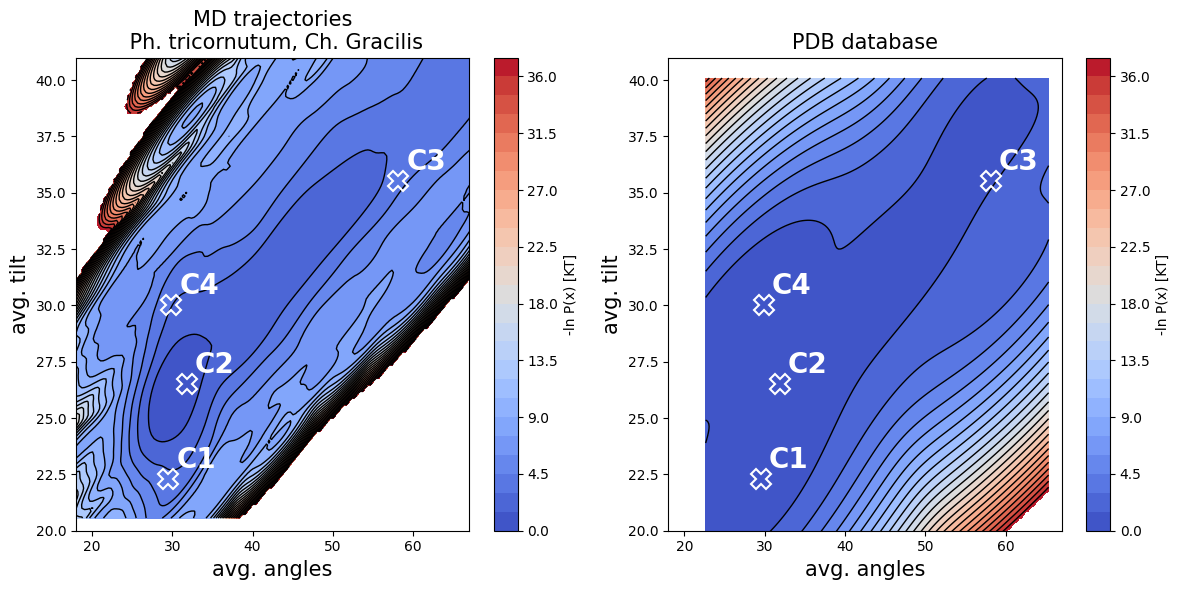

In [12]:
# plot the energies
fig, ax = plt.subplots(1,2,figsize=(12, 6))
cmap = plt.get_cmap("gnuplot_r")
c_pdb = ax[1].contour(X_pdb, Y_pdb, F_masked_pdb, levels=27, colors='black', linewidths=1)
cf_pdb = ax[1].contourf(X_pdb, Y_pdb, F_masked_pdb, levels=27, cmap='coolwarm')
cbar_pdb = plt.colorbar(cf_pdb, label="-ln P(x) [KT]")
ax[1].set_xlabel("avg. angles",fontsize='15')
ax[1].set_ylabel("avg. tilt",fontsize='15')
ax[1].set_xlim([18,67])
ax[1].set_ylim([20,41])
ax[1].set_title('PDB database',fontsize='15')
c_xtc = ax[0].contour(X_xtc, Y_xtc, F_masked_xtc, levels=27, colors='black', linewidths=1)
cf_xtc = ax[0].contourf(X_xtc, Y_xtc, F_masked_xtc, levels=27, cmap='coolwarm')
cbar_xtc = plt.colorbar(cf_xtc, label="-ln P(x) [KT]")
ax[0].set_xlabel("avg. angles",fontsize='15')
ax[0].set_ylabel("avg. tilt",fontsize='15')
ax[0].set_xlim([18,67])
ax[0].set_ylim([20,41])
ax[0].set_title('MD trajectories\n Ph. tricornutum, Ch. Gracilis',fontsize='15')

# Add circles and labels
for label, (x, y) in points.items():
    ax[1].plot(x, y, marker='X', color='white', markersize=15, 
               markerfacecolor='none', markeredgewidth=1.5)
    ax[0].plot(x, y, marker='X', color='white', markersize=15, 
               markerfacecolor='none', markeredgewidth=1.5)
    ax[1].text(x + 1, y+0.5, label, fontsize=20, color='white',weight='bold')
    ax[0].text(x + 1, y+0.5, label, fontsize=20, color='white',weight='bold')

plt.tight_layout()
plt.savefig("Free_Energy_Surface.png", bbox_inches='tight', dpi=600, format='png')
plt.show()